<a href="https://colab.research.google.com/github/Patrick95T/Lab1/blob/master/Lab_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

KeyboardInterrupt: ignored

# Base Model


## Importing relevant libraries


In [ ]:
import json
import keras
import pandas as pd
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.model_selection import train_test_split

### Exploring data


In [ ]:
train = pd.read_csv('train.csv')
# split the data into train and test set
train, test = train_test_split(train, test_size=0.1, random_state=42, shuffle=True)

In [ ]:
train_x = train['text']
train_y = train['target']
test_x = test['text']
test_y = test['target']

## Preprocessing


In [ ]:
train_x = np.array(train_x)
train_y = np.array(train_y)


# only work with the 3000 most popular words found in our dataset
max_words = 10000

# create a new Tokenizer
tokenizer = Tokenizer(num_words=max_words)
# feed our tweets to the Tokenizer
tokenizer.fit_on_texts(train_x)

# Tokenizers come with a convenient list of words and IDs
dictionary = tokenizer.word_index

# Saving the dictionary
with open('dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)

# padding tockenized text so that it is all the same length(longest word's length).
def convert_text_to_index_array(text):
    return [dictionary[word] for word in kpt.text_to_word_sequence(text)]

allWordIndices = []
# for each tweet, change each token to its ID in the Tokenizer's word_index
for text in train_x:
    wordIndices = convert_text_to_index_array(text)
    allWordIndices.append(wordIndices)

#array of tweets as indeces(words replaced with indexes)
allWordIndices = np.asarray(allWordIndices)

# create one-hot matrices out of the indexed tweets
train_x = tokenizer.sequences_to_matrix(allWordIndices, mode='binary')
# treat the labels as categories
train_y = keras.utils.to_categorical(train_y, 2)

## Model


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping

logdir = "logs/scalars/"
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

model = Sequential()
model.add(Dense(512, input_shape=(max_words,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])


history = model.fit(train_x, train_y,
    batch_size=16,
    epochs=10,
    verbose=1,
    validation_split=0.1,
    shuffle=True,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)],
)

model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('model.h5')

print('saved model!')


Epoch 1/10
386/386 [==============================] - 10s 26ms/step - loss: 0.5585 - accuracy: 0.7157 - val_loss: 0.4364 - val_accuracy: 0.8134
Epoch 2/10
386/386 [==============================] - 10s 25ms/step - loss: 0.3285 - accuracy: 0.8631 - val_loss: 0.4430 - val_accuracy: 0.8120
Epoch 00002: early stopping
saved model!


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


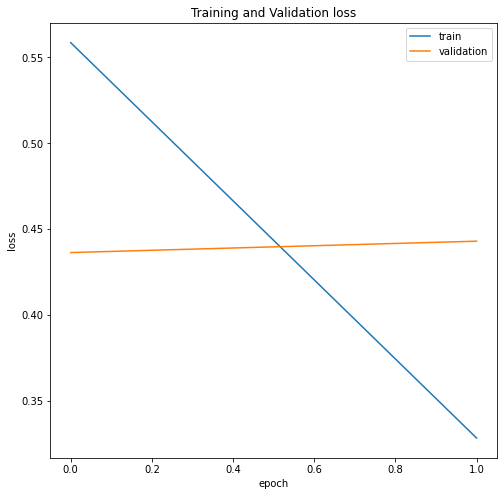

In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
import json
from keras.models import model_from_json
# we're still going to use a Tokenizer here, but we don't need to fit it
tokenizer = Tokenizer(num_words=10000)
# for human-friendly printing
labels = ['fake', 'real']

# read in our saved dictionary
with open('dictionary.json', 'r') as dictionary_file:
    dictionary = json.load(dictionary_file)

def convert_text_to_index_array(text):
    words = kpt.text_to_word_sequence(text)
    wordIndices = []
    for word in words:
        if word in dictionary:
            wordIndices.append(dictionary[word])
        else:
          pass
            # print("'%s' not in training corpus; ignoring." %(word))
    return wordIndices

# read in your saved model structure
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
# and create a model from that
model = model_from_json(loaded_model_json)
# and weight your nodes with your saved values
model.load_weights('model.h5')

predictions = []

f = open("output.txt","w")
for index_of_interest, text1 in enumerate(test_x):
    # format your input for the neural net
    testArr = convert_text_to_index_array(text1)
    input = tokenizer.sequences_to_matrix([testArr], mode='binary')
    # predict which bucket your input belongs in

    # format your input for the neural net
    testArr = convert_text_to_index_array(text1)
    input = tokenizer.sequences_to_matrix([testArr], mode='binary')
        # predict which bucket your input belongs in
    pred = model.predict(input)

    predictions.append(np.argmax(pred))


        # and print it for the humons
    # print("line: %s the %s sentiment; %f%% confidence" % (test_y[index_of_interest] ,labels[np.argmax(pred)], pred[0][np.argmax(pred)] * 100))
    # f.write("line: %s; - %s tweet; %f%% confidence \n" % (test_y[index_of_interest] ,labels[np.argmax(pred)], pred[0][np.argmax(pred)] * 100))

AttributeError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
predictions = np.array(predictions)
test_y = np.array(test_y)
confusion_matrix(test_y, predictions)

tn, fp, fn, tp = confusion_matrix(test_y, predictions).ravel()
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn +tp)
falsePositiveRate = fp / (fp + tn)
falsePositiveRate

0.09624413145539906